In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

"""
quick and dirty N-body simulation using Hooke's law springs
to test the performance of numba
"""
    

# convert subindex (i,j) to linear index (idx)
def sub2ind(array_shape, i, j):
    idx = i*array_shape[1] + j
    return idx




# simulation main loop

""" N-body simulation """

# Simulation parameters
N         = 8      # Number of nodes per linear dimension
t         = 0      # current time of the simulation
dt        = 0.01    # timestep
Nt        = 160000   # number of timesteps
spring_coeff = 100  # Hooke's law spring coefficient
plotRealTime = False # switch on for plotting as the simulation goes along


# construct spring nodes / initial conditions
boxsize = 3
xlin = np.linspace(0.5,0.5+(0.25*N),N)

x, y = np.meshgrid(xlin, xlin)
x = x.flatten()
y = y.flatten()

pos = np.vstack((x,y)).T
vel = np.zeros(pos.shape)
acc = np.zeros(pos.shape)

# add a bit of random noise
# np.random.seed(17)            # set the random number generator seed
# vel += 0.01*np.random.randn(N**2,2)


random_phi = np.random.rand((N**2)+1)*2
random_phi[0] = 0

# construct spring network connections
ci = []
cj = []

# construct diagional springs
cd = []

#  o--o
for r in range(0,N):
	for c in range(0,N-1):
		idx_i = sub2ind([N, N], r, c)
		idx_j = sub2ind([N, N], r, c+1)
		ci.append(idx_i)
		cj.append(idx_j)
		cd.append(0)
# o
# |
# o
for r in range(0,N-1):
	for c in range(0,N):
		idx_i = sub2ind([N, N], r, c)
		idx_j = sub2ind([N, N], r+1, c)
		ci.append(idx_i)
		cj.append(idx_j)	
		cd.append(0)
# o
#   \
#     o
print(cd)
counter = 1
for r in range(0,N-1):
	for c in range(0,N-1):
		idx_i = sub2ind([N, N], r, c)
		idx_j = sub2ind([N, N], r+1, c+1)
		ci.append(idx_i)
		cj.append(idx_j)
		cd.append(counter)	
		counter += 1
#     o
#   /
# o
counter = 1
for r in range(0,N-1):
	for c in range(0,N-1):
		idx_i = sub2ind([N, N], r+1, c)
		idx_j = sub2ind([N, N], r, c+1)
		ci.append(idx_i)
		cj.append(idx_j)
		cd.append(counter)
		counter += 1



# calculate spring rest-lengths
springL = np.linal-g.norm( pos[ci,:] - pos[cj,:], axis = 1)


A = 1  # scaling factor - if A=1, then spring extension range is 2 (sides) * 3.5mm (measured per side)
f = 0.85
alpha = 0.33
t_cycle = 2
t_motion = 1/f
t_fixed = t_cycle - t_motion
d_1 = (t_cycle * alpha) - t_motion/2
actuation_constants = np.array([A,f,t_cycle,t_motion,t_fixed,d_1])


# friction parameters
Fcoulomb = 0.172
Fstatic = 0
Fbrk = 0.172 #Fcoulomb + Fstatic
F_coeff = np.array([Fbrk, Fcoulomb, Fstatic])
Vbrk = 0.01
Vcoul = Vbrk/10
Vst = Vbrk * np.sqrt(2)
B = 4
V_coeff = np.array([Vbrk, Vcoul, Vst, B])

# physics functions
@njit(fastmath=True)
def actuation_length(t_current, ac): 
	# t_current is the local unit time now; ac = [A, f, t_cycle, t_motion, t_fixed, d_1]
	t_all = t_current % ac[2] - ac[3]/4; delta_l = 0.0035  # in m, you get this expansion on each side
	omega = ac[1]*2*np.pi
	counter = 0
	for t in t_all:
		if t < ac[3]/4:  # extension rise
			t_current[counter] =  ac[0] * (np.sin(omega * t) + 1) * delta_l
		elif t >= ac[3]/4 and t < (ac[3]/4 + ac[5]):  # extension plateau 
			t_current[counter] = ac[0] * (np.sin(omega * ac[3]/4) + 1) * delta_l
		elif t >= (ac[3]/4 + ac[5]) and t < (3/4 * ac[3] + ac[5]):  # extension fall
			t_current[counter] = ac[0] * (np.sin(omega * (t - ac[5])) + 1) * delta_l
		elif t >= (3/4 * ac[3] + ac[5]) and t < (3/4 * ac[3] + ac[4]):  # extension low plateau (contracted)
			t_current[counter] = ac[0] * (np.sin(omega * ac[3] * 3/4) + 1) * delta_l
		elif t > (ac[3] * 3/4 + ac[4]):  # extention rise back to zero
			t_current[counter] = ac[0] * (np.sin(omega * (t - ac[4])) + 1) * delta_l

		counter += 1

	t_current[0] = 0
	return t_current






	





[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [52]:
# set random initial conditions
random_phi = np.random.sample((N*N)+1)

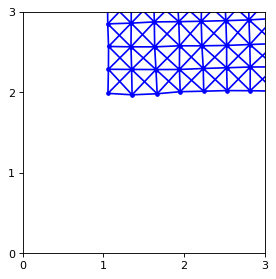

In [4]:
"""
quick and dirty calculation of the acceleration on each node
to intergrate the equations of motion using forward euler
"""
import numba as nb
# calculate acceleration on nodes using hooke's law + gravity
@njit()
def getAcc(pos, vel, ci, cj, springL, spring_coeff, acc, V_coeff, F_coeff):

	
	sep_vec = pos[ci,:] - pos[cj,:]
	# sep = np.linalg.norm( sep_vec, axis = 1)
	# # sep_vec
	# print(sep)
	sep = np.sqrt(sep_vec[:,0]**2+sep_vec[:,1]**2)
	# print(sep)
	dL = sep - springL
	ax = - spring_coeff * dL * sep_vec[:,0] / sep
	ay = - spring_coeff * dL * sep_vec[:,1] / sep
	for i in range(len(ci)): acc[:,0][ci[i]] += ax[i]
	for i in range(len(ci)): acc[:,1][ci[i]] += ay[i]
	for i in range(len(ci)): acc[:,0][cj[i]] += -ax[i]
	for i in range(len(ci)): acc[:,1][cj[i]] += -ay[i]
	
	v_length = np.where(vel[:,0]+vel[:,1]==0,1,np.sqrt(vel[:,0]**2+vel[:,1]**2))

	acc[:,0] += -(2.3316439*(F_coeff[2])*np.exp(-(v_length/V_coeff[2])**2)*(v_length/V_coeff[2]) + F_coeff[1]*np.tanh(v_length/V_coeff[1]) + v_length* V_coeff[3] ) * (vel[:,0]/v_length)
	acc[:,1] += -(2.3316439*(F_coeff[2])*np.exp(-(v_length/V_coeff[2])**2)*(v_length/V_coeff[2]) + F_coeff[1]*np.tanh(v_length/V_coeff[1]) + v_length* V_coeff[3] ) * (vel[:,1]/v_length)


	return acc

# prep figure
fig = plt.figure(figsize=(4,4), dpi=80)
ax = fig.add_subplot(111)

# Simulation Main Loop for forward euler
@njit()
def simLoop(t, Nt, dt, pos, vel, ci, cj, cd, springL, spring_coeff, V_coeff, F_coeff, actuation_constants, plotRealTime = False):
	for i in range(Nt):

		# drift
		pos += vel * dt
		

		
		# update accelerations
		acc = np.zeros(pos.shape)
		l_add = actuation_length(random_phi+t, actuation_constants)
		# print(l_add[cd]*1000)
		acc = getAcc( pos, vel, ci, cj, springL+(l_add[cd]*10), spring_coeff,acc, V_coeff, F_coeff)
		vel += acc * dt/2.0
		# update time
		t += dt
	return pos, vel, acc

pos, vel, acc = simLoop(t, Nt, dt, pos, vel, np.array(ci), np.array(cj), np.array(cd), springL, spring_coeff, V_coeff, F_coeff, actuation_constants, plotRealTime = False)
	
# plot in real time

plt.cla()
plt.plot(pos[[ci, cj],0],pos[[ci, cj],1],color='blue')
plt.scatter(pos[:,0],pos[:,1],s=10,color='blue')
ax.set(xlim=(0, boxsize), ylim=(0, boxsize))
ax.set_aspect('equal', 'box')
ax.set_xticks([0,1,2,3])
ax.set_yticks([0,1,2,3])
plt.show()

In [5]:
from scipy.integrate import solve_ivp
"""
quick and dirty calculation of the acceleration on each node
to intergrate the equations of motion using ivp_solver
"""


@njit()
def getAcc(pos, vel, ci, cj, springL, spring_coeff, acc, V_coeff, F_coeff):

	
	# # Hooke's law: F = - k * displacement along spring
	sep_vec = pos[ci,:] - pos[cj,:]
	sep = np.sqrt(sep_vec[:,0]**2+sep_vec[:,1]**2)
	dL = sep - springL
	ax = - spring_coeff * dL * sep_vec[:,0] / sep
	ay = - spring_coeff * dL * sep_vec[:,1] / sep
	for i in range(len(ci)): acc[:,0][ci[i]] += ax[i]
	for i in range(len(ci)): acc[:,1][ci[i]] += ay[i]
	for i in range(len(ci)): acc[:,0][cj[i]] += -ax[i]
	for i in range(len(ci)): acc[:,1][cj[i]] += -ay[i]

	v_length = np.where(vel[:,0]+vel[:,1]==0,1,np.sqrt(vel[:,0]**2+vel[:,1]**2))
	acc[:,0] += -(2.3316439*(F_coeff[2])*np.exp(-(v_length/V_coeff[2])**2)*(v_length/V_coeff[2]) + F_coeff[1]*np.tanh(v_length/V_coeff[1]) + v_length* V_coeff[3] ) * (vel[:,0]/v_length)
	acc[:,1] += -(2.3316439*(F_coeff[2])*np.exp(-(v_length/V_coeff[2])**2)*(v_length/V_coeff[2]) + F_coeff[1]*np.tanh(v_length/V_coeff[1]) + v_length* V_coeff[3] ) * (vel[:,1]/v_length)

	return acc

@njit()	
def ivp_function(t, Y, Nt, dt, pos, vel, ci, cj, cd, springL, spring_coeff, V_coeff, F_coeff, actuation_constants):
	U = np.zeros(len(Y[int(len(Y)/2):len(Y)]))
	U = Y[int(len(Y)/2):len(Y)]
	V = np.zeros(len(Y[0:int(len(Y)/2)]))
	V = Y[0:int(len(Y)/2)]

	# # drift
	pos = U.reshape((int(len(U)/2),2)) + pos
	vel = V.reshape((int(len(V)/2),2))


	# update accelerations
	acc = np.zeros(pos.shape)

	l_add = actuation_length(random_phi+t, actuation_constants)
	# print(l_add[cd]*1000)
	acc = getAcc( pos, vel, ci, cj, springL+(l_add[cd]*10), spring_coeff,acc, V_coeff, F_coeff)
	Y[0:int(len(Y)/2)] = acc.reshape(int(len(acc)*2))
	Y[int(len(Y)/2):int(len(Y))] = V
	return Y

In [6]:

"""
quick and dirty calculation of the acceleration on each node
to intergrate the equations of motion using ivp_solver
"""

t_end = 10000
sol = solve_ivp(ivp_function, [0, t_end], np.concatenate((acc.reshape(len(acc)*2),vel.reshape(len(vel)*2))), args=(Nt, dt, pos, vel, np.array(ci), np.array(cj), np.array(cd), springL, spring_coeff, V_coeff, F_coeff, actuation_constants),t_eval=np.linspace(0, t_end, t_end*10),max_step=0.3)
print(sol.y.shape)

(256, 1)


In [7]:
from numbalsoda import lsoda_sig, lsoda
from numba import njit, cfunc
import numpy as np

"""
quick and dirty calculation of the acceleration on each node
to intergrate the equations of motion using lsoda
"""

@cfunc(lsoda_sig)
def rhs(t, u, du, p):
    du[0] = u[0]-u[0]*u[1]
    du[1] = u[0]*u[1]-u[1]*p[0]

funcptr = rhs.address # address to ODE function
u0 = np.array([5.,0.8]) # Initial conditions
data = np.array([1.0]) # data you want to pass to rhs (data == p in the rhs).
t_eval = np.linspace(0.0,50.0,1000) # times to evaluate solution

# integrate with lsoda method
usol, success = lsoda(funcptr, u0, t_eval, data = data)

# # integrate with dop853 method
# usol1, success1 = dop853(funcptr, u0, t_eval, data = data)

